In [1]:
import os
import shutil
import random
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sn
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib.path import Path
from sklearn.metrics import classification_report, confusion_matrix

from keras.optimizers import Adam

from dltk.io.augmentation import *


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Data loading and preprocessing

In [2]:
# dirpath = "./data"
# if os.path.exists(dirpath) and os.path.isdir(dirpath):
#     shutil.rmtree(dirpath)

In [3]:
from src.arrange_dataset import arrange_dataset

data_dir = arrange_dataset() 
print(data_dir)

Dataset arranged in ./data
./data


In [4]:
from src.data_loader3D import NiiSequence, dataGenerator
from sklearn.model_selection import train_test_split

batch_size = 16
nb_classes = 4

train_set, train_labels = dataGenerator(data_dir, mode="train", nb_classes=nb_classes)
test_set, test_labels = dataGenerator(data_dir, mode="val", nb_classes=nb_classes)
train_set, val_set, train_labels, val_labels = train_test_split(train_set, train_labels, test_size=0.2, random_state=42, shuffle=True)

print("Train set size: ", len(train_set))
print("Validation set size: ", len(val_set))
print("Test set size: ", len(test_set))

Train set size:  457
Validation set size:  115
Test set size:  146


In [5]:
def check_CN(path):
    return "CN" in path

def check_SMCI(path):
    return "SMCI" in path

def check_PMCI(path):
    return "PMCI" in path

def check_AD(path):
    return "AD" in path

train = [0]*4
train[0] = list(filter(check_CN,train_set))
train[1] = list(filter(check_SMCI,train_set))
train[2] = list(filter(check_PMCI,train_set))
train[3] = list(filter(check_AD,train_set))

lst = [len(train[0]), len(train[1]), len(train[2]), len(train[3])]

max_class = lst.index(max(lst))
max_len = lst[max_class]

train_labels=[]
train_set = []
for i in range(4):
    diff = max_len - len(train[i])
    print(diff)
    more_data = train[i][:diff]
    if more_data:
        print("len",len(more_data))
        train[i].extend(more_data)
    train_set.extend(train[i])
    train_labels+= [i]*max_len

# AUG Lab1 et lab2
# train_labels = list(train_labels)

# train_1 = list(filter(check_SMCI,train_set))
# lab1 = [1]*len(train_1)
# train_set += train_1
# train_labels += lab1

# train_2 = list(filter(check_PMCI,train_set))
# lab2 = [2]*len(train_2)
# train_set += train_2
# train_labels += lab2

zipped = list(zip(train_set, train_labels))
random.shuffle(zipped)
train_set, train_labels = zip(*zipped)

train_labels = np.array(train_labels)

0
62
len 62
26
len 26
19
len 19


In [6]:
print(max_len)
print(len(train[0]),len(train[1]), len(train[2]), len(train[3]))
assert len(train[0]) ==len(train[1]) ==len(train[2]) ==len(train[3])

141
141 141 141 141


In [7]:
train_sequence = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False)
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['gaussian_offset', 'gaussian_noise', 'shiftIntensity', 'adjustContrast'])
val_sequence = NiiSequence(val_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False)
test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC", shuffle=False)

print("Shape of one MRI element:", train_sequence[0][0].shape)
print("Train label example after loading:", train_sequence[0][1])

print("Shape of one batch:", test_sequence[0][0].shape)
print("Test label example after loading:", test_sequence[0][1])

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
Shape of one batch: (16, 40, 40, 80, 1)
Test label example after loading: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [8]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (15, 40, 40, 80, 1)
Train label example after loading: (15, 4)


Scan Visualization

282


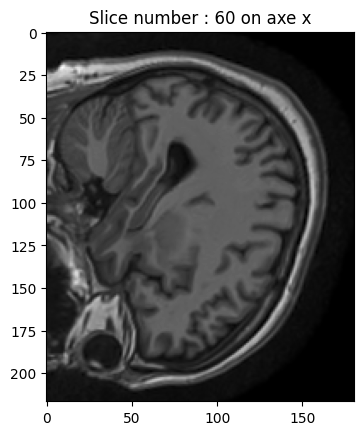

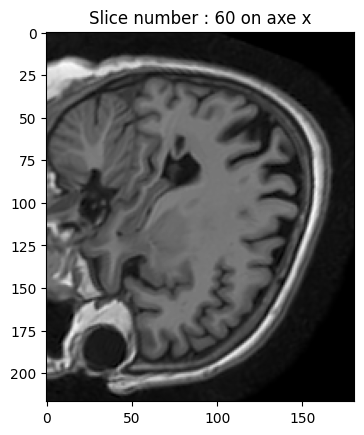

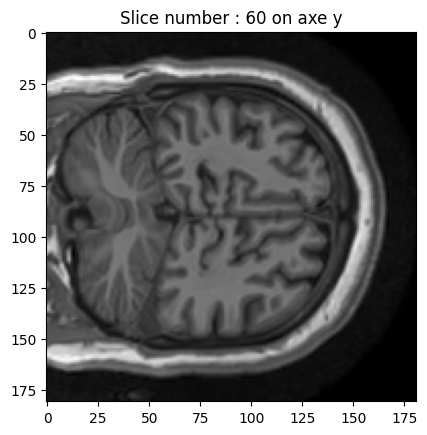

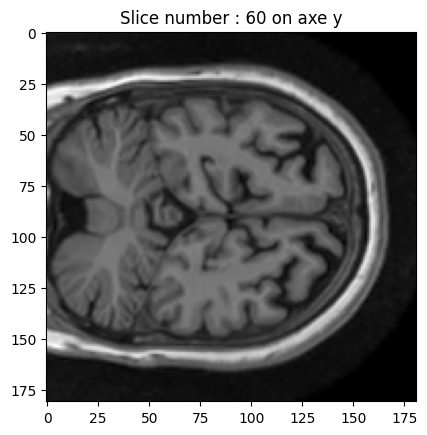

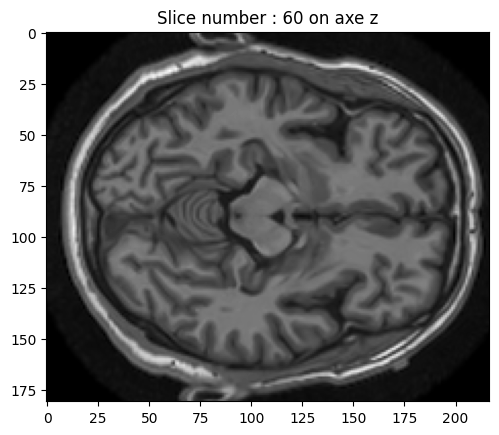

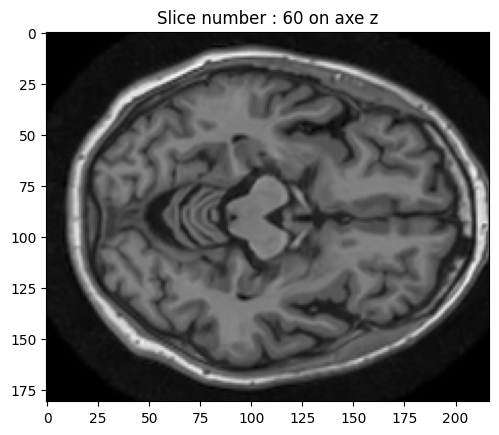

In [9]:
# MRI images are composed by many slices, build a montage of the them
def show_2D(irm, slice, axe):
    if axe == "x":
        plt.imshow(irm[slice,:,:], cmap="gray")
    elif axe == "y":
        plt.imshow(irm[:,slice,:], cmap="gray")
    elif axe == "z":
        plt.imshow(irm[:,:,slice], cmap="gray")
    plt.title("Slice number : " + str(slice) + " on axe " + axe)
    plt.show()

firstAug = int(train_set.__len__()/2)
img = nib.load(train_set[0])
print(firstAug)
img2 = nib.load(train_set[firstAug])

show_2D(img.get_fdata(), 60, "x")
show_2D(img2.get_fdata(), 60, "x")

show_2D(img.get_fdata(), 60, "y")
show_2D(img2.get_fdata(), 60, "y")

show_2D(img.get_fdata(), 60, "z")
show_2D(img2.get_fdata(), 60, "z")

Imbalanced Data

{'CN': 227, 'SMCI': 129, 'PMCI': 171, 'AD': 191}


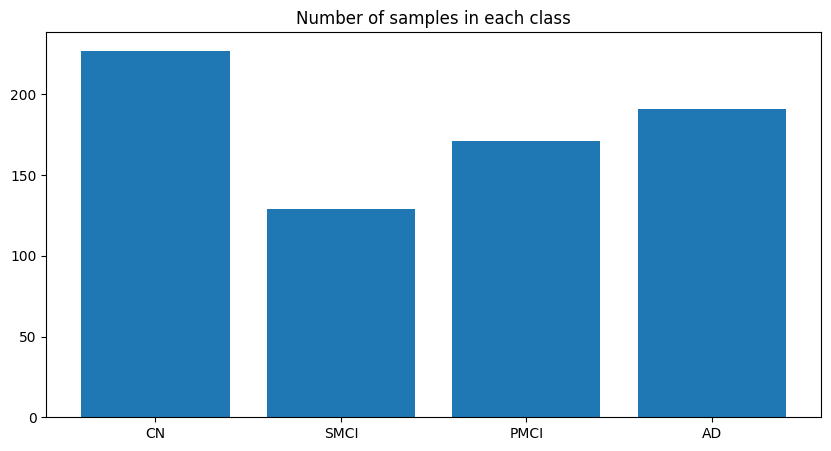

In [10]:
## Calculate number of samples in each class.
input_folder = 'lib'
class_counts = dict()
class_names = ["CN", "SMCI", "PMCI", "AD"]
if nb_classes == 2:
    class_names = ["CN", "AD"]
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

print(class_counts)

# plot the number of samples in each class
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of samples in each class')
plt.show()

# 3D Convolutional Neural Network without data augmentation

In [11]:
from src.bi_classifier3D import Biclassifier3D

input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
print("Input shape:", input_shape)
bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.4)
model = bicl.build_model()
model.summary()
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy'],
)

Input shape: (40, 40, 80, 1)


/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_4 (Conv3D)           (None, 40, 40, 80, 8)     224       
                                                                 
 activation_4 (Activation)   (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_5 (Activation)   (None, 40, 40, 80, 8)     0         
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 20, 20, 40, 8)    0         
 3D)                                                             
                                                             

Model training

In [12]:
# checkpoint
filepath="classifier3D_test_lol-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr]

In [13]:
model.fit(
    train_sequence,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=10,
)

Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 16.8940 - accuracy: 0.2996
Epoch 1: val_accuracy improved from -inf to 0.26786, saving model to classifier3D_test_lol-01-0.27.hdf5
36/36 [==============================] - 110s 3s/step - loss: 16.8940 - accuracy: 0.2996 - val_loss: 2.7321 - val_accuracy: 0.2679 - lr: 1.0000e-04
Epoch 2/10
 4/36 [==>...........................] - ETA: 1:23 - loss: 2.2881 - accuracy: 0.2812

KeyboardInterrupt: 

Visualizing Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


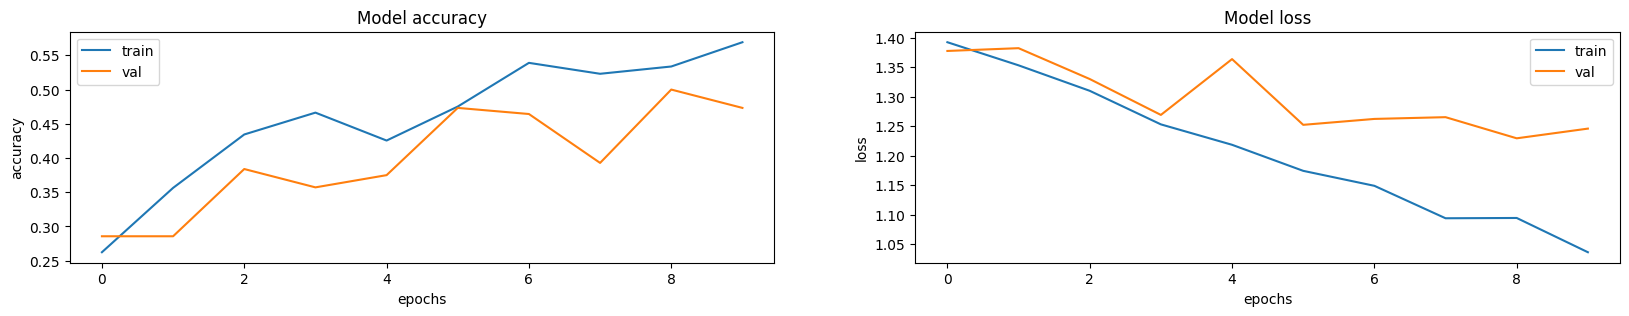

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

print(model.history.history.keys())
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Model Evaluation

In [15]:
# test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC", shuffle=False)
model.evaluate(test_sequence, verbose=1)

10/10 [==============================] - 18s 2s/step - loss: 1.1837 - accuracy: 0.4726


[1.1836812496185303, 0.4726027250289917]

In [16]:
y = model.predict(test_sequence)

10/10 [==============================] - 18s 2s/step


In [17]:
y_pred = y.argmax(axis=1)
y_test = np.array(test_labels)
print(y_pred)
print(y_test)

[0 0 0 0 0 0 2 0 1 1 0 0 0 0 0 0 2 0 2 1 1 0 0 3 2 0 0 2 1 0 0 2 0 0 1 0 0
 0 0 0 0 0 2 2 0 0 0 0 2 0 2 1 3 2 0 1 0 0 0 0 2 0 1 3 1 2 2 2 0 0 3 3 3 2
 2 2 2 2 2 2 2 2 0 2 3 2 0 2 3 3 2 3 2 3 2 3 3 0 1 3 3 3 3 2 2 0 3 3 0 3 3
 2 2 2 3 2 2 3 3 2 3 2 3 3 3 3 1 0 2 3 2 3 2 3 0 0 2 3 3 2 2 2 2 2 3 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


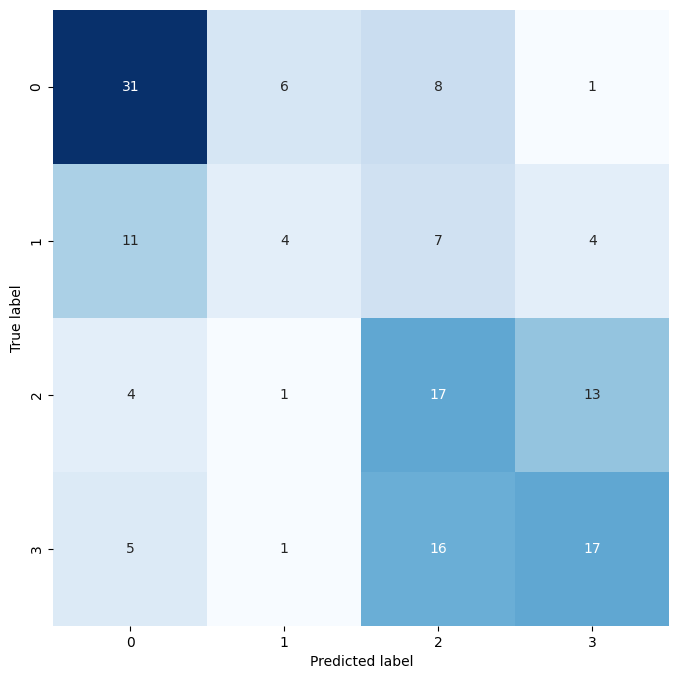

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

36/36 [==============================] - 70s 2s/step


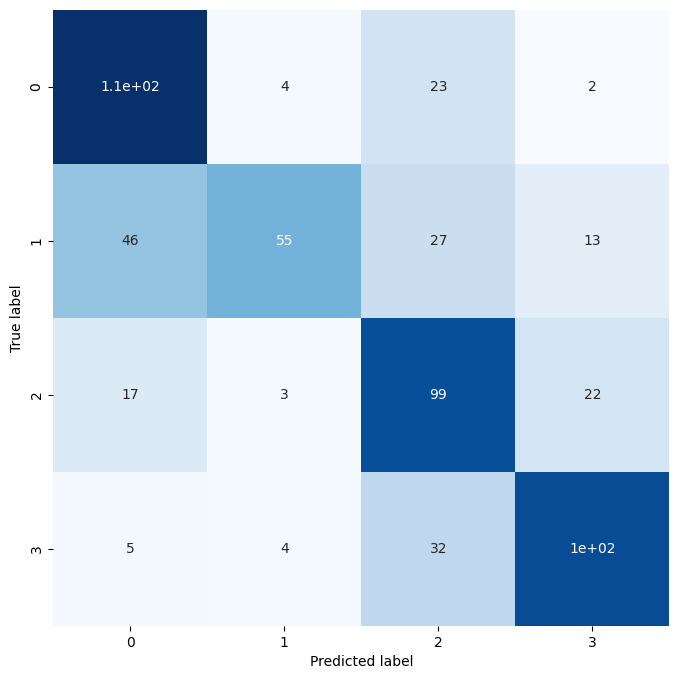

In [19]:
y = model.predict(train_sequence)
y_pred = y.argmax(axis=1)
y_train = np.array(train_labels)
# print(y_pred)
# print(y_train)

cm = confusion_matrix(y_train, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Neural network with data augmentation

In [20]:
# directory = "./lib/AD"
# file_path = os.listdir(directory)[0]
# img = nib.load(os.path.join(directory,file_path)).get_fdata()

# # Modifications

# # Randomly flip the image along axis 1
# t1_flipped = flip(img.copy(), axis=1)
# # Add a Gaussian offset (independently for each channel)
# t1_offset = add_gaussian_offset(img.copy(), sigma=20)

# # Add Gaussian noise
# t1_noise = add_gaussian_noise(img.copy(), sigma=25)
# t1_trans_low_s = elastic_transform(img.copy(), alpha=[1, 1, 1], sigma=[50, 50, 50])
# t1_trans_high_s = elastic_transform(img.copy(), alpha=[100, 2e5, 2e5], sigma=[100, 250, 250])


# def show_2D(irm, slice, axe):
#     if axe == "x":
#         # plt.imshow(irm[slice,:,:], cmap="gray", vmin=0, vmax=255)
#         plt.imshow(irm[slice,:,:], cmap="gray")

#     elif axe == "y":
#         # plt.imshow(irm[:,slice,:], cmap="gray", vmin=0, vmax=255)
#         plt.imshow(irm[:,slice,:], cmap="gray")

#     elif axe == "z":
#         # plt.imshow(irm[:,:,slice], cmap="gray", vmin=0, vmax=255)
#         plt.imshow(irm[:,:,slice], cmap="gray")

#     plt.title("Slice number : " + str(slice) + " on axe " + axe)
#     plt.colorbar()
#     plt.show()

# show_2D(img, 60, "x")
# show_2D(t1_offset, 60, "x")
# show_2D(t1_noise, 60, "x")
# show_2D(t1_flipped, 60, "x")
# show_2D(t1_trans_low_s, 60, "x")
# show_2D(t1_trans_high_s, 60, "x")

# show_2D(img, 60, "y")
# show_2D(img, 60, "z")

In [14]:
from src.bi_classifier3D import Biclassifier3D

input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
print("Input shape:", input_shape)
bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.4)
model = bicl.build_model()
model.summary()
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy'],
)

Input shape: (40, 40, 80, 1)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_12 (Conv3D)          (None, 40, 40, 80, 8)     224       
                                                                 
 activation_14 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_13 (Conv3D)          (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_15 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 20, 20, 40, 8)    0         
 3D)                                                             
                              

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [15]:
# checkpoint
filepath="classifier3D_test-dataAug-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop]

In [16]:
model.fit(
    train_sequence_aug,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=20,
)

Epoch 1/20
177/177 [==============================] - ETA: 0s - loss: 3.6544 - accuracy: 0.2734
Epoch 1: val_accuracy improved from -inf to 0.24107, saving model to classifier3D_test-dataAug-01-0.24.hdf5
177/177 [==============================] - 136s 767ms/step - loss: 3.6544 - accuracy: 0.2734 - val_loss: 1.3612 - val_accuracy: 0.2411
Epoch 2/20
 23/177 [==>...........................] - ETA: 1:48 - loss: 1.2856 - accuracy: 0.4162

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


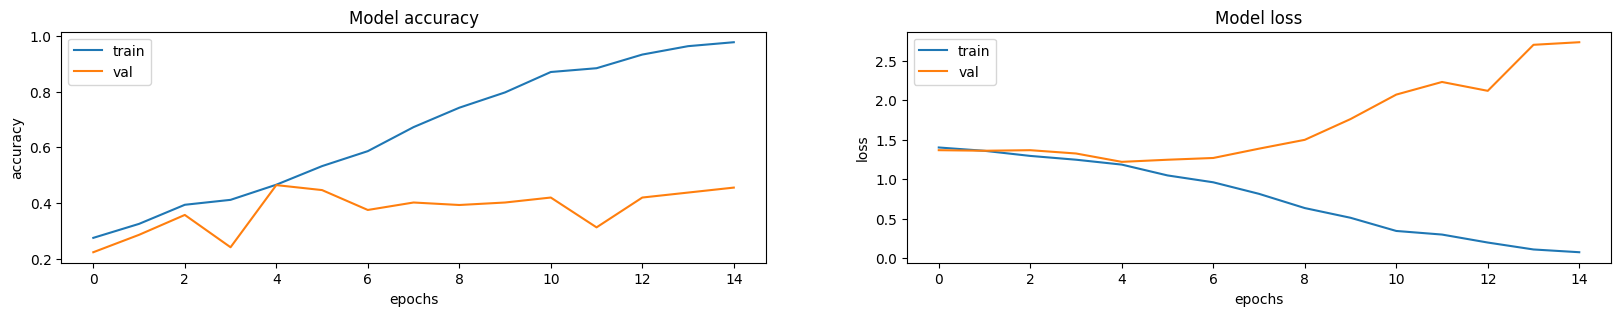

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

print(model.history.history.keys())
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

In [25]:
model.evaluate(test_sequence, verbose=1)

10/10 [==============================] - 20s 2s/step - loss: 3.0509 - accuracy: 0.4315


[3.0508689880371094, 0.43150684237480164]

In [26]:
y = model.predict(test_sequence)
y_pred = y.argmax(axis=1)
y_test = np.array(test_labels)
print(y_pred)
print(y_test)

10/10 [==============================] - 18s 2s/step
[1 0 0 0 0 0 0 2 1 0 0 0 0 0 1 0 0 0 3 2 1 0 0 3 0 0 0 0 0 0 0 0 0 0 1 2 0
 0 1 0 0 0 3 0 0 0 0 1 2 2 2 1 3 2 0 0 0 1 2 0 3 0 0 3 0 2 0 2 0 2 3 3 3 2
 0 2 0 2 2 2 2 0 0 0 1 0 2 2 3 1 2 3 3 3 0 3 3 0 1 2 1 3 3 0 3 1 3 0 0 2 3
 3 2 2 2 2 2 3 2 3 3 2 3 3 3 3 1 0 3 2 2 2 3 3 2 2 2 3 1 2 3 3 2 3 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


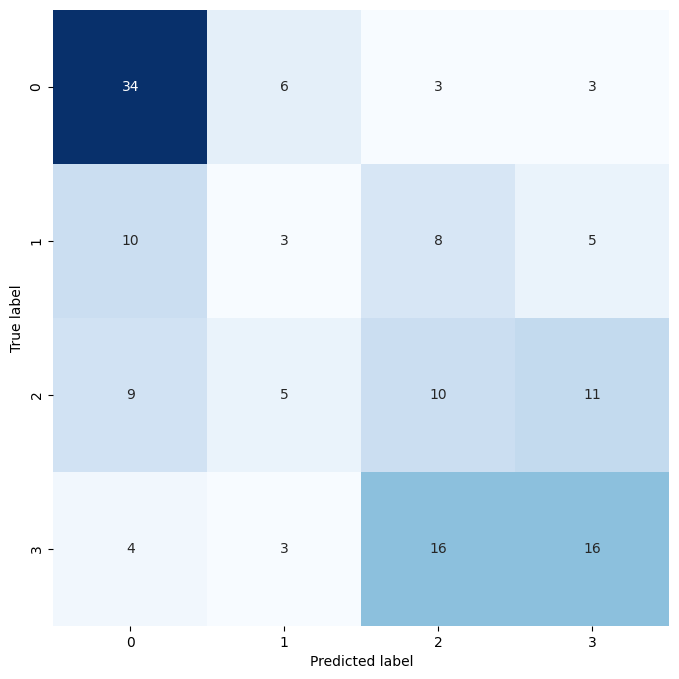

In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

36/36 [==============================] - 75s 2s/step


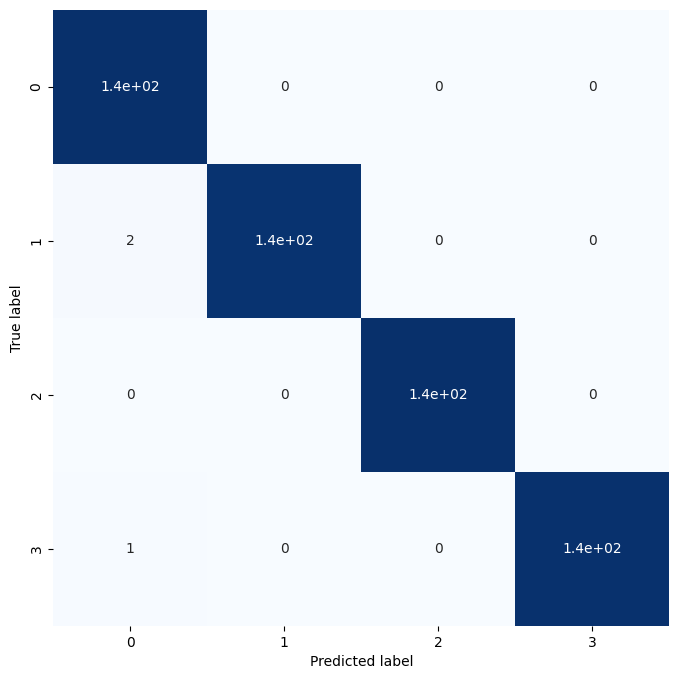

In [28]:
y = model.predict(train_sequence)
y_pred = y.argmax(axis=1)
y_train = np.array(train_labels)
# print(y_pred)
# print(y_train)

cm = confusion_matrix(y_train, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()